<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/Transfer_learning_and_finetuningNov7v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://www.tensorflow.org/tutorials/images/transfer_learning

Dataset - stratified sample of APTOS (356 images total)

In [53]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
train_dir = '/content/drive/MyDrive/cfPublicData/aptos2/train_small'
test_dir = '/content/drive/MyDrive/cfPublicData/aptos2/test_small'
train_labels_path = '/content/drive/MyDrive/cfPublicData/aptos2/train_small.csv'
test_labels_path = '/content/drive/MyDrive/cfPublicData/aptos2/test_small.csv'

In [56]:
train_labels_df = pd.read_csv(train_labels_path)
test_labels_df = pd.read_csv(test_labels_path)
print(train_labels_df.info())
print(test_labels_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    256 non-null    object
 1   diagnosis  256 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 4.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    110 non-null    object
 1   diagnosis  110 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
None


In [57]:
train_labels_df['diagnosis'] = train_labels_df['diagnosis'].astype(int)
test_labels_df['diagnosis'] = test_labels_df['diagnosis'].astype(int)

In [58]:
train_labels_df['id_code'] = train_labels_df['id_code'].apply(lambda x: f'{x}.png')
test_labels_df['id_code'] = test_labels_df['id_code'].apply(lambda x: f'{x}.png')

In [59]:
train_df, validate_df = train_test_split(train_labels_df, test_size=0.2, random_state=27, stratify=train_labels_df['diagnosis'])
test_df = test_labels_df

In [60]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
validate_df.reset_index(drop=True, inplace=True)

In [ ]:
#validate_df.head()

In [63]:
print(train_df.info())

print(validate_df.info())

print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    204 non-null    object
 1   diagnosis  204 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    52 non-null     object
 1   diagnosis  52 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 960.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    110 non-null    object
 1   diagnosis  110 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
None


In [65]:
target_size = (160, 160) # test change from 224
batch_size = 32

In [66]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [67]:
def augment_img(image):
    image = tf.expand_dims(image, 0)
    image = data_augmentation(image)
    image = tf.squeeze(image, 0)
    return image

In [68]:
datagen_train = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=augment_img  # Apply data augmentation
)
datagen_validate = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    class_mode='raw',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=True
)

validate_generator = datagen_validate.flow_from_dataframe(
    dataframe=validate_df,
    directory=train_dir,
    x_col='id_code',
    y_col='diagnosis',
    class_mode='raw',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id_code',
    y_col='diagnosis',
    class_mode='raw',
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False
)

Found 204 validated image filenames.
Found 52 validated image filenames.
Found 110 validated image filenames.


In [69]:
label_map = {0 : "No DR",1 : "Mild",2 : "Moderate",3 :"Severe",4 : "Proliferative DR"}

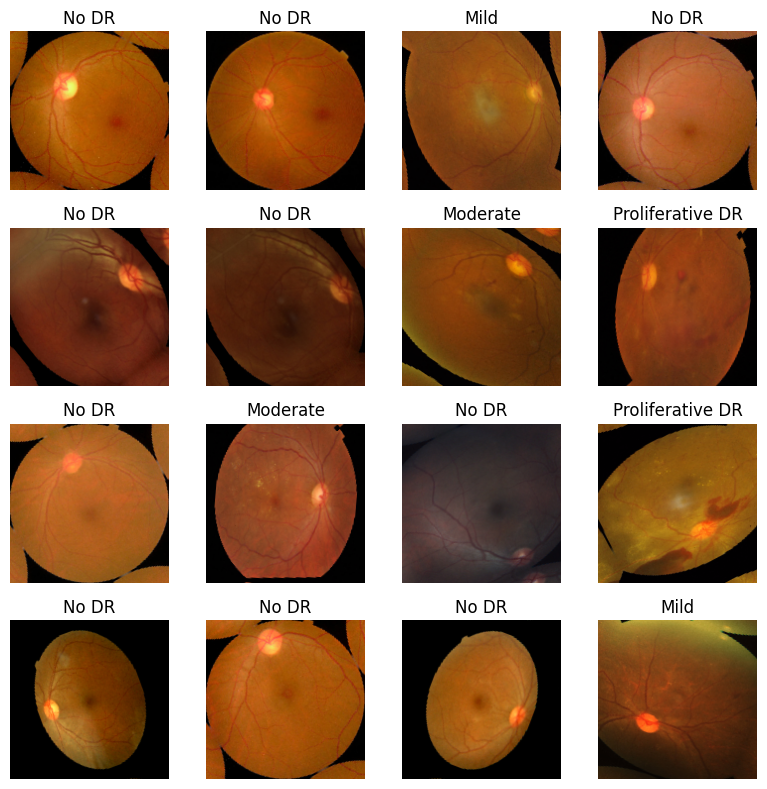

In [70]:
batch_images, batch_labels = next(train_generator)


fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i in range(16):

    if i < len(batch_images):
        ax = axes[i // 4, i % 4]
        ax.imshow(batch_images[i])
        label_text = label_map.get(int(batch_labels[i]), "Unknown")
        ax.set_title(label_text)  #
        ax.axis('off')  # Hide the axis


plt.tight_layout()
plt.show()

In [71]:
# Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [72]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = target_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [73]:
# Feature extraction - converts (test 160x160x3) 224x224x3 image into a 7x7x1280 block of features
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)


In [74]:
image_batch, label_batch = next(iter(train_generator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [75]:
base_model.trainable = False

In [76]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [77]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [78]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [79]:
inputs = tf.keras.Input(shape=(160, 160, 3)) # test 224 and 160
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [80]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [81]:
len(model.trainable_variables)

2

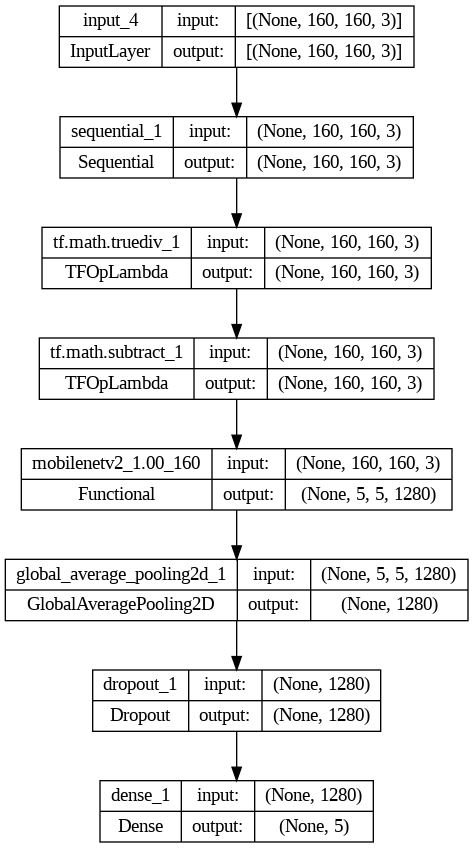

In [82]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [83]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)


In [84]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(validate_generator)

2/2 [==============================] - 8s 3s/step - loss: 2.0270 - accuracy: 0.2692


In [85]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.03
initial accuracy: 0.27


In [86]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validate_generator)

Epoch 1/5
7/7 [==============================] - 42s 6s/step - loss: 2.0904 - accuracy: 0.1618 - val_loss: 1.8589 - val_accuracy: 0.2692
Epoch 2/5
7/7 [==============================] - 32s 5s/step - loss: 1.9162 - accuracy: 0.1814 - val_loss: 1.7100 - val_accuracy: 0.2692
Epoch 3/5
7/7 [==============================] - 36s 5s/step - loss: 1.8186 - accuracy: 0.1814 - val_loss: 1.5864 - val_accuracy: 0.2692
Epoch 4/5
7/7 [==============================] - 31s 5s/step - loss: 1.6331 - accuracy: 0.2451 - val_loss: 1.4845 - val_accuracy: 0.2692
Epoch 5/5
7/7 [==============================] - 32s 5s/step - loss: 1.5274 - accuracy: 0.3088 - val_loss: 1.4097 - val_accuracy: 0.2692


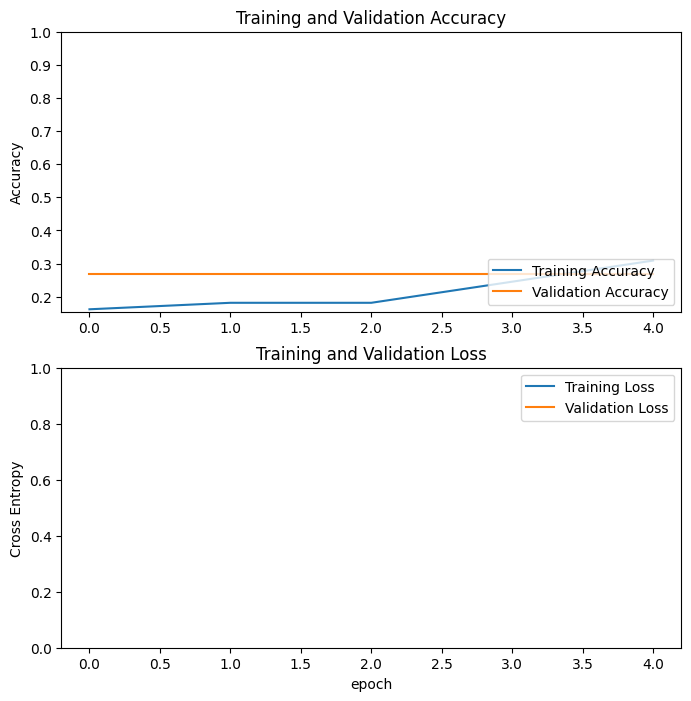

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [88]:
base_model.trainable = True

In [89]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [90]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [91]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, None, None, None   0         
                             )                                   
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                   

In [92]:
len(model.trainable_variables)

56

In [93]:
# Continue training the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validate_generator)

Epoch 5/15
7/7 [==============================] - 47s 6s/step - loss: 1.5149 - accuracy: 0.4559 - val_loss: 1.3059 - val_accuracy: 0.5000
Epoch 6/15
7/7 [==============================] - 31s 5s/step - loss: 1.3537 - accuracy: 0.4706 - val_loss: 1.3096 - val_accuracy: 0.5000
Epoch 7/15
7/7 [==============================] - 32s 5s/step - loss: 1.3582 - accuracy: 0.4559 - val_loss: 1.3012 - val_accuracy: 0.5000
Epoch 8/15
7/7 [==============================] - 32s 4s/step - loss: 1.3574 - accuracy: 0.4657 - val_loss: 1.2924 - val_accuracy: 0.5000
Epoch 9/15
7/7 [==============================] - 36s 5s/step - loss: 1.3764 - accuracy: 0.4069 - val_loss: 1.2921 - val_accuracy: 0.5000
Epoch 10/15
7/7 [==============================] - 31s 4s/step - loss: 1.3514 - accuracy: 0.4510 - val_loss: 1.2891 - val_accuracy: 0.5000
Epoch 11/15
7/7 [==============================] - 31s 5s/step - loss: 1.3186 - accuracy: 0.4853 - val_loss: 1.3008 - val_accuracy: 0.5000
Epoch 12/15
7/7 [===============

In [94]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

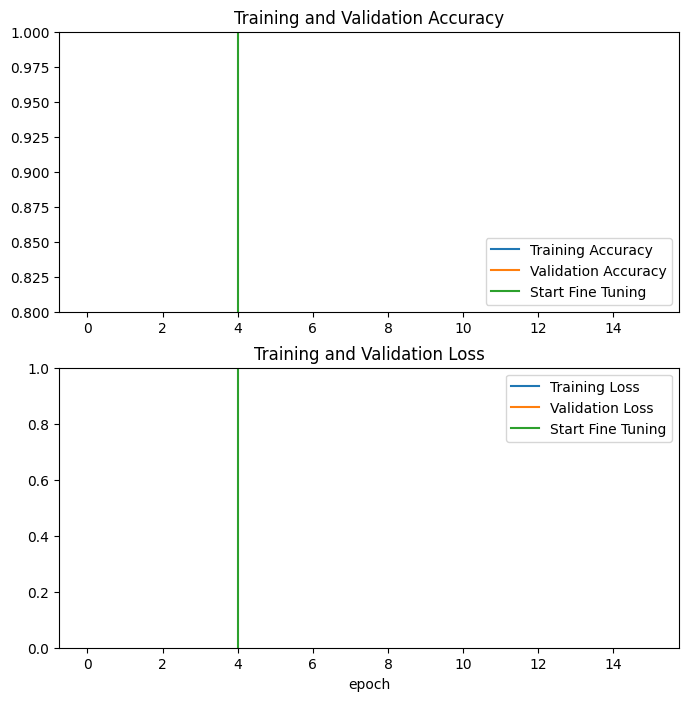

In [95]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [96]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

4/4 [==============================] - 12s 3s/step - loss: 1.3183 - accuracy: 0.4909
Test accuracy : 0.4909090995788574


In [101]:
train_df.head()

,id_code,diagnosis
0,4bd5d0b30198.png,0
1,1fd5d860d4d7.png,4
2,90c982cc2d96.png,1
3,4ef7144e24ff.png,1
4,f431f2e119d7.png,0
